In [1]:
# pip install ultralytics
from ultralytics import YOLO
import os, math
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from typing import List, Any, Union

C:\Users\Utilisateur\OneDrive - Groupe ESAIP\Bureau\Cetic_code\pythonProject1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

ds = load_dataset("parquet", data_files="data/mmimdb_merged.parquet", split="train")

In [4]:
print(ds[0])

{'messages': [{'role': 'user', 'content': 'Given the movie poster and the corresponding plot of the movie, choose the appropriategenres from the following comma separated genres: drama, comedy, romance, thriller, crime, action, adventure,horror, documentry, mystery, sci-fi, fantasy, family, biography, war, history, music, animation, musical,western, sport, short, film-noir.\nPlot: Mild mannered businessman Anthony Wongs life is shattered when his pregnant wife is run over by a busy taxi driver. This and another incident with a sleazy cab driver causes Wong to go on a mission to kill bad taxi drivers.\nNote that a movie can belong to more than one genres,provide all the suitable genres separated by commas. Answer:'}, {'role': 'assistant', 'content': 'Crime, Drama, Thriller'}], 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=265x475 at 0x2462FFF2FD0>]}


Map (num_proc=1): 100%|██████████| 15552/15552 [46:52<00:00,  5.53 examples/s] 


  genres  mean_warmth  median_warmth      n
0    nan     0.698017       0.826156  15552


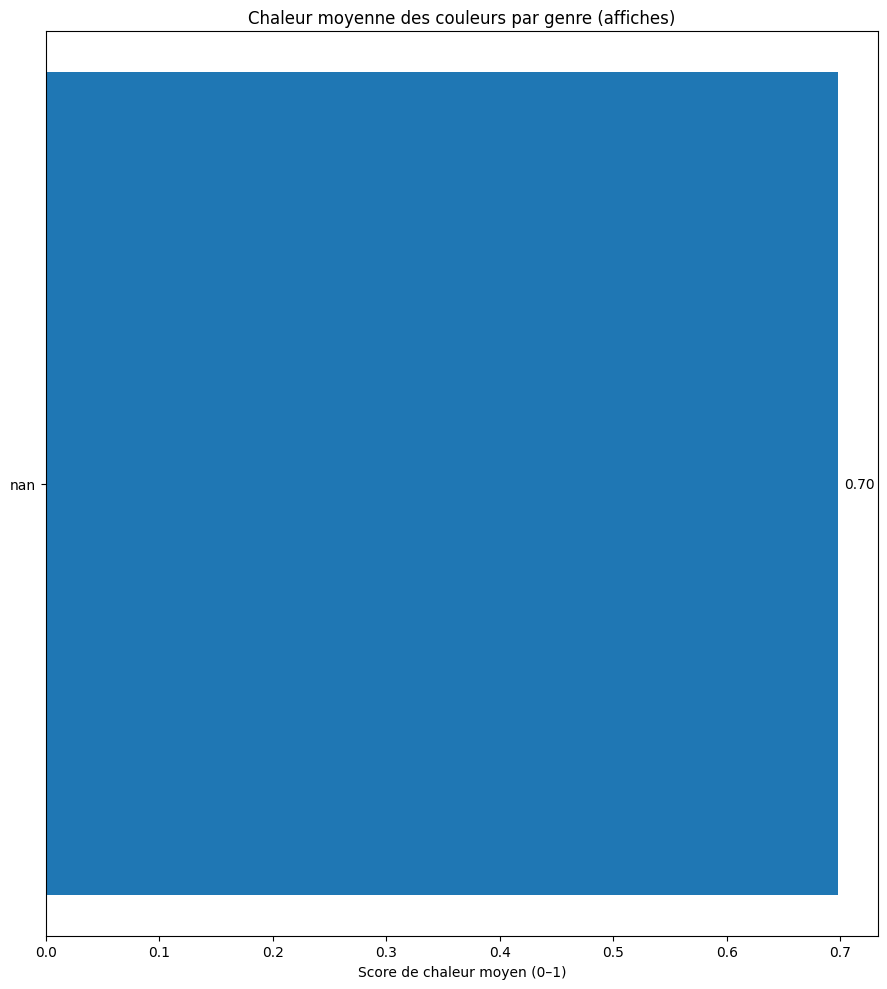

In [34]:
# --- 1) Score de chaleur (HSV via PIL, pas d'OpenCV) ---
def warmth_score_hsv_pil(img: Image.Image) -> float:
    """
    Score ~ fraction de pixels 'chauds' (rouge/orange/jaune) pondérée par la saturation,
    en ignorant les pixels très sombres et très peu saturés.
    Retourne un float entre 0 et 1.
    """
    if img.mode != "RGB":
        img = img.convert("RGB")
    hsv = img.convert("HSV")
    arr = np.array(hsv).astype(np.float32)  # H,S,V in [0..255]
    H = arr[..., 0] * (360.0 / 255.0)
    S = arr[..., 1] / 255.0
    V = arr[..., 2] / 255.0

    # Masques anti-bruit
    valid = (V > 0.15) & (S > 0.15)

    # Teintes chaudes: [0°,75°] U [300°,360°]
    warm = ((H >= 0) & (H <= 75)) | ((H >= 300) & (H <= 360))

    weights = S * valid
    warm_w = (warm * weights).sum()
    total_w = weights.sum()
    return float(warm_w / total_w) if total_w > 0 else 0.0

from PIL import Image

def ensure_pil(x):
    """
    Retourne un objet PIL.Image.Image à partir de ce que renvoie la colonne 'images'.
    - Si c'est déjà une Image -> la retourne
    - Si c'est une liste [Image] -> retourne le premier élément
    - Sinon -> None
    """
    if isinstance(x, Image.Image):
        return x
    if isinstance(x, list) and len(x) > 0 and isinstance(x[0], Image.Image):
        return x[0]
    return None
def extract_genres(msg: Any) -> List[str]:
    """
    Tente plusieurs formats possibles:
    - dict avec 'genres' (liste de str)
    - dict avec 'genres' (string "A|B|C")
    - string "A|B|C" ou "A, B, C"
    """
    if isinstance(msg, dict):
        # Essaye plusieurs clés plausibles
        for k in ["genres", "genre", "labels", "tags"]:
            if k in msg:
                val = msg[k]
                if isinstance(val, list):
                    return [str(v).strip() for v in val if str(v).strip()]
                if isinstance(val, str):
                    sep = "|" if "|" in val else ","
                    return [v.strip() for v in val.split(sep) if v.strip()]
    if isinstance(msg, str):
        sep = "|" if "|" in msg else ","
        return [v.strip() for v in msg.split(sep) if v.strip()]
    return []

# --- 2) Charger le dataset HF ---
ds = load_dataset("parquet", data_files="data/mmimdb_merged.parquet", split="train")

# --- 3) Calculer chaleur + genres (par batch pour la vitesse) ---
from PIL import Image
import numpy as np

def compute_batch(batch):
    from PIL import Image
    import numpy as np
    from typing import Any, List
#<<<<----------------------------<>>>>>>>>>>>>>>>>
    # --- 1) Score de chaleur (défini localement pour les workers) ---
    def warmth_score_hsv_pil(img: Image.Image) -> float:
        if img.mode != "RGB":
            img = img.convert("RGB")
        hsv = img.convert("HSV")
        arr = np.array(hsv).astype(np.float32)  # H,S,V in [0..255]
        H = arr[..., 0] * (360.0 / 255.0)
        S = arr[..., 1] / 255.0
        V = arr[..., 2] / 255.0
        valid = (V > 0.15) & (S > 0.15)
        warm = ((H >= 0) & (H <= 75)) | ((H >= 300) & (H <= 360))
        weights = S * valid
        warm_w = (warm * weights).sum()
        total_w = weights.sum()
        return float(warm_w / total_w) if total_w > 0 else 0.0

    # --- 2) Extracteur de genres (défini localement aussi) ---
    def extract_genres(msg: Any) -> List[str]:
        if isinstance(msg, dict):
            for k in ["genres", "genre", "labels", "tags"]:
                if k in msg:
                    val = msg[k]
                    if isinstance(val, list):
                        return [str(v).strip() for v in val if str(v).strip()]
                    if isinstance(val, str):
                        sep = "|" if "|" in val else ","
                        return [v.strip() for v in val.split(sep) if v.strip()]
        if isinstance(msg, str):
            sep = "|" if "|" in msg else ","
            return [v.strip() for v in msg.split(sep) if v.strip()]
        return []

    imgs = batch["images"]
    msgs = batch["messages"]
    warmths, genres = [], []

    for im, msg in zip(imgs, msgs):
        if isinstance(im, Image.Image):
            pil = im
        elif isinstance(im, list) and len(im) > 0 and isinstance(im[0], Image.Image):
            pil = im[0]
        else:
            pil = None

        score = np.nan if pil is None else warmth_score_hsv_pil(pil)
        warmths.append(score)
        genres.append(extract_genres(msg))

    return {"warmth": warmths, "genres": genres}


#<<<<----------------------------<>>>>>>>>>>>>>>>>


ds = ds.map(compute_batch, batched=True, batch_size=64, num_proc=1)


# --- 4) Agrégation par genre ---
# Convertir en pandas pour exploiter explode / groupby (15k lignes = OK en RAM)
df = ds.to_pandas()

# Supprimer NaN chaleu
df = df.dropna(subset=["warmth"])

# Exploser la liste de genres en lignes
df_exploded = df.explode("genres")
df_exploded["genres"] = df_exploded["genres"].astype(str).str.strip()
df_exploded = df_exploded[df_exploded["genres"] != ""]

agg = (df_exploded
       .groupby("genres", as_index=False)
       .agg(mean_warmth=("warmth", "mean"),
            median_warmth=("warmth", "median"),
            n=("warmth", "count"))
       .sort_values("mean_warmth", ascending=False))

print(agg.head(10))

# --- 5) Visualisation : "carte" simple = barres triées ---
plt.figure(figsize=(9, 10))
plt.barh(agg["genres"], agg["mean_warmth"])
plt.gca().invert_yaxis()
plt.xlabel("Score de chaleur moyen (0–1)")
plt.title("Chaleur moyenne des couleurs par genre (affiches)")
for i, v in enumerate(agg["mean_warmth"]):
    plt.text(v + 0.005, i, f"{v:.2f}", va="center")
plt.tight_layout()
plt.show()

In [6]:
print(ds[0]['images'])
img = ds[85]["images"]
model = YOLO("yolo11s.pt")
print(model.names)

# 2) Nombre de classes
print(len(model.names))  # 80 ≈ COCO (généraliste). Petit nombre = souvent spécialisé.

# 3) Type de tâche (détection/seg/pose/obb)
print(model.task)  # 'detect', 'segment', 'pose', etc.

# Inférence sur une image
results = model(img)  # renvoie boîtes, classes, scores
results[0].show()
# évaluer sur COCO (val2017)
model("image.jpg")  # prédire


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=265x475 at 0x21D3095DBA0>]
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63:

FileNotFoundError: image.jpg does not exist

In [29]:
img = ds[1540]["images"]
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis("off")
plt.show()

AttributeError: 'list' object has no attribute 'show'

In [28]:
# Charger un modèle pré-entraîné (détection)
model = YOLO("yolov8n.pt")  # n = nano (rapide et léger)

# 1) Liste des classes apprises
print(model.names)  # dict: id -> nom de classe

# 2) Nombre de classes
print(len(model.names))  # 80 ≈ COCO (généraliste). Petit nombre = souvent spécialisé.

# 3) Type de tâche (détection/seg/pose/obb)
print(model.task)  # 'detect', 'segment', 'pose', etc.

# Inférence sur une image
results = model(img)  # renvoie boîtes, classes, scores
results[0].show()  # affiche l’image annotée

# Fine-tuning sur vos données (format COCO ou dossier/images + labels .txt)
# model.train(data="data.yaml", epochs=50, imgsz=640)


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [3]:
def rgb_to_hsl(R, G, B):
    r, g, b = R / 255.0, G / 255.0, B / 255.0
    M, m = max(r, g, b), min(r, g, b)
    L = (M + m) / 2.0
    if M == m:
        return 0.0, 0.0, L
    d = M - m
    S = d / (1 - abs(2 * L - 1))
    if M == r:
        H = ((g - b) / d) % 6
    elif M == g:
        H = (b - r) / d + 2
    else:
        H = (r - g) / d + 4
    H *= 60.0
    return H, S, L


img2 = ds[1540]["images"]


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=317x475 at 0x1C7A68D5A90>]


In [ ]:
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [ ]:
init_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png")

In [ ]:
prompt = "cat biker, moto, sons of anarchy, detailed, scary, adorable"
image = pipeline(prompt, image=init_image).images[0]
make_image_grid([init_image, image], rows=1, cols=2)